# CIFAR-10 VAE

In [1]:
from projectlib.imports import *
from projectlib.datasets import cifar10
from projectlib.vae import VAE, Sampling
from projectlib.viz import view_images, plot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
%matplotlib inline

In [2]:
def get_encoder(input_shape, latent_dim):
    encoder_inputs = Input(shape=input_shape)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=(4, 4), padding='same')(encoder_inputs)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', strides=(3, 3), padding='same')(x)
    x = Conv2D(filters=128, kernel_size=3, activation='relu', strides=(3, 3), padding='same')(x)
    x = Reshape((128,))(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z])
    encoder._input_shape = input_shape
    encoder._latent_dim = latent_dim
    return encoder

def get_decoder(latent_dim):
    latent_inputs = Input(shape=(latent_dim, ))
    x = Dense(128)(latent_inputs)
    x = Reshape((1,1,128,))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    decoded = Conv2DTranspose(filters=3, kernel_size=3, activation='sigmoid', strides=(2, 2), padding='same')(x)
    
    decoder = Model(latent_inputs, decoded)
    decoder._latent_dim = latent_dim
    return decoder

def get_classifier(encoder, n_classes):
    encoder_inputs = Input(shape=encoder._input_shape)
    _, _, encoded = encoder(encoder_inputs)
    x = Dense(32, activation='relu')(encoded)
    x = Dense(64, activation='relu')(x)
    output = Dense(n_classes, activation='softmax')(x)
    classifier = Model(encoder_inputs, output)
    classifier._input_shape = encoder._input_shape
    classifier._latent_dim = encoder._latent_dim
    classifier._n_classes = n_classes
    return classifier

## CIFAR10

In [3]:
X, y = cifar10.load_data(frac=0.1)
input_shape = X[0].shape

y_ohe = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, train_size=0.8, shuffle=True, random_state=42)

print(X_train.shape)
print(y_train.shape)

(5600, 28, 28, 1)
(5600, 10)


In [4]:
latent_dim = 64

In [5]:
encoder = get_encoder(input_shape, latent_dim)
#plot_model(encoder, show_shapes=True, show_layer_names=False, expand_nested=True)

In [6]:
decoder = get_decoder(latent_dim)
#plot_model(decoder, show_shapes=True, show_layer_names=False, expand_nested=True)

In [7]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

In [8]:
training_config = Munch(batch_size=32,
                        num_epochs=3,
                        verbose=2)
history = vae.fit(X_train, X_test, **training_config)

.....Epoch 0: {'loss': 60.006817, 'reconstruction_loss': 59.792805, 'kl_loss': 0.2140121}
.....Epoch 1: {'loss': 50.700825, 'reconstruction_loss': 50.310356, 'kl_loss': 0.39046857}
.....Epoch 2: {'loss': 44.08852, 'reconstruction_loss': 43.500328, 'kl_loss': 0.58819085}


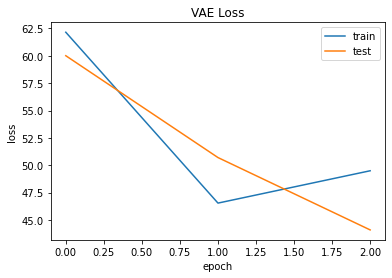

In [9]:
plot(labels=['train', 'test'],
     plots=(history['loss'], history['val_loss']),
     title='VAE Loss',
     xlabel='epoch',
     ylabel='loss')

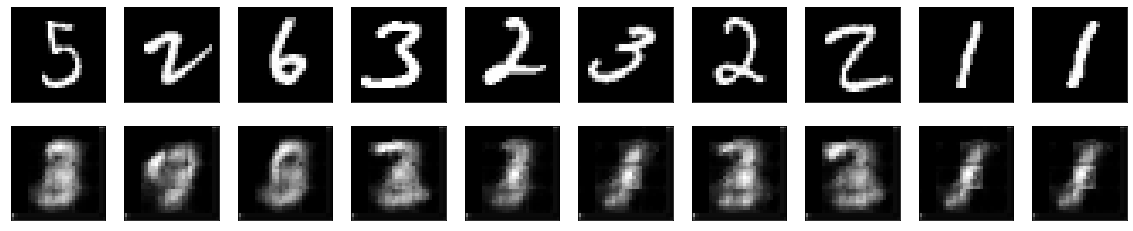

In [10]:
view_images(X_test[:10], decoder, encoder)

In [11]:
classifier = get_classifier(encoder, cifar10.n_classes)
#plot_model(classifier, show_shapes=True, show_layer_names=False, expand_nested=True)

In [12]:
classifier.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)
history = classifier.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
175/175 [==============================] - 4s 22ms/step - loss: 1.5209 - categorical_accuracy: 0.4588 - val_loss: 1.0345 - val_categorical_accuracy: 0.6336
Epoch 2/10
175/175 [==============================] - 4s 21ms/step - loss: 0.9315 - categorical_accuracy: 0.6814 - val_loss: 0.8462 - val_categorical_accuracy: 0.7093
Epoch 3/10
175/175 [==============================] - 4s 21ms/step - loss: 0.7899 - categorical_accuracy: 0.7257 - val_loss: 0.7973 - val_categorical_accuracy: 0.7179
Epoch 4/10
175/175 [==============================] - 4s 21ms/step - loss: 0.7077 - categorical_accuracy: 0.7566 - val_loss: 0.7175 - val_categorical_accuracy: 0.7493
Epoch 5/10
175/175 [==============================] - 4s 22ms/step - loss: 0.6552 - categorical_accuracy: 0.7729 - val_loss: 0.6624 - val_categorical_accuracy: 0.7729
Epoch 6/10
175/175 [==============================] - 4s 22ms/step - loss: 0.6052 - categorical_accuracy: 0.7929 - val_loss: 0.6415 - val_categorical_accuracy: 0.776

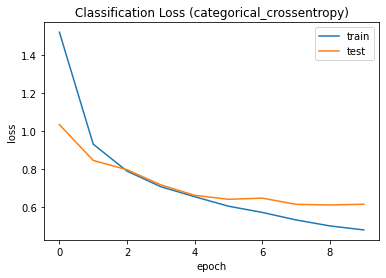

In [13]:
plot(labels=['train', 'test'],
     plots=(history.history['loss'], history.history['val_loss']),
     title='Classification Loss (categorical_crossentropy)',
     xlabel='epoch',
     ylabel='loss')

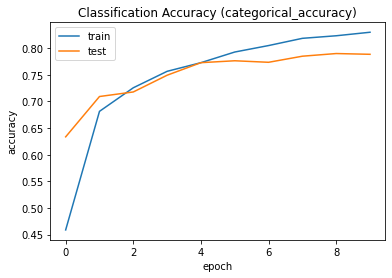

In [14]:
plot(labels=['train', 'test'],
     plots=(history.history['categorical_accuracy'],
            history.history['val_categorical_accuracy']),
     title='Classification Accuracy (categorical_accuracy)',
     xlabel='epoch',
     ylabel='accuracy')